In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import seaborn as sns
import scipy.stats as stats

import tensorflow as tf
import gpflow

2025-10-27 21:29:38.274201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/super_stas_69/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gpflow/versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [8]:
load_dotenv()
PATH2fold0 = os.getenv("PATH2fold0")

In [9]:
X_gp_df = pd.read_csv(PATH2fold0 + 'emb_train.csv')
Y_pred_df = pd.read_csv(PATH2fold0 + 'uv_pred_train.csv')
Y_true_df = pd.read_csv(PATH2fold0 + 'train_full.csv') 

In [10]:
def scale_spectra(data):
    for i, row in data.iterrows():
        scaled_row = (row.values - np.min(row.values)) / (np.max(row.values) - np.min(row.values))
        data.loc[i] = scaled_row

    return data

In [12]:
X_gp_train = X_gp_df.iloc[:, 1:].values.astype(np.float64)
Y_pred_train_scaled = scale_spectra(Y_pred_df.iloc[:, 1:]).values.astype(np.float64)
Y_true_train = Y_true_df.iloc[:, 1:].values.astype(np.float64)

Y_residuals_train = Y_true_train - Y_pred_train_scaled

In [13]:
# Гиперпараметры для обучения GP
learning_rate = 0.01
training_iterations = 100
kernel_type = 'RBF' # Возможные значения: 'RBF', 'Matern'

spectrum_len = Y_residuals_train.shape[1]
gp_models = []

print(f"\nНачинаем обучение {spectrum_len} независимых GP моделей...")

for i in range(spectrum_len):
    print(f"Обучение GP для точки спектра {i+1}/{spectrum_len}...")

    # GPflow ожидает Y как массив с формой (N, D), где D=1 для одномерного вывода
    current_y_residuals = Y_residuals_train[:, i:i+1]

    # Выбор ядра GP
    if kernel_type == 'RBF':
        kernel = gpflow.kernels.SquaredExponential()
    elif kernel_type == 'Matern':
        kernel = gpflow.kernels.Matern52() # Matern32 или Matern52
    else:
        raise ValueError("Неподдерживаемое ядро. Используйте 'RBF' или 'Matern'.")

    # Создаем модель Gaussian Process Regression (GPR)
    # mean_function=None по умолчанию использует gpflow.mean_functions.ZeroMean
    model = gpflow.models.GPR(
        (X_gp_train, current_y_residuals),
        kernel=kernel,
        mean_function=None
    )

    # Оптимизатор Adam для обучения GP-модели
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    # Функция потерь (отрицательное логарифмическое правдоподобие)
    # Используем tf.function для компиляции в граф TensorFlow и ускорения
    @tf.function(autograph=False)
    def objective_closure():
        return -model.log_marginal_likelihood()

    # Обучение модели
    for iter_step in range(training_iterations):
        optimizer.minimize(objective_closure, var_list=model.trainable_variables)
        # Отладочный вывод (раскомментируйте при необходимости)
        # if (iter_step + 1) % 10 == 0:
        #     loss_val = objective_closure().numpy()
        #     print(f"  Точка {i+1}, Итерация {iter_step+1}/{training_iterations}, Loss: {loss_val:.4f}")

    gp_models.append(model)

print("Обучение всех GP моделей завершено.")


Начинаем обучение 181 независимых GP моделей...
Обучение GP для точки спектра 1/181...


2025-10-27 21:33:22.512714: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-10-27 21:33:23.624587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:33:23.690201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:33:23.69356

Обучение GP для точки спектра 2/181...


2025-10-27 21:33:55.383673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:33:55.450231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:33:55.453007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 3/181...


2025-10-27 21:34:28.797669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:34:28.920952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:34:28.924708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 4/181...


2025-10-27 21:35:04.530297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:35:04.628634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:35:04.633581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 5/181...


2025-10-27 21:35:37.779860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:35:37.858144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:35:37.862226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 6/181...


2025-10-27 21:36:08.811385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:36:08.885060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:36:08.887569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 7/181...


2025-10-27 21:36:40.254644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:36:40.316613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:36:40.320047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 8/181...


2025-10-27 21:37:11.663176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:37:11.737401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:37:11.739843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 9/181...


2025-10-27 21:37:43.644952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:37:43.717004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:37:43.719780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 10/181...


2025-10-27 21:38:15.355906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:38:15.433717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:38:15.437918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 11/181...


2025-10-27 21:38:51.096873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:38:51.185209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:38:51.190460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 12/181...


2025-10-27 21:39:27.081289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:39:27.167934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:39:27.171379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 13/181...


2025-10-27 21:40:04.165489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:40:04.247401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:40:04.252021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 14/181...


2025-10-27 21:40:43.312697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:40:43.406741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:40:43.409744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 15/181...


2025-10-27 21:41:21.108365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:41:21.201776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:41:21.205930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 16/181...


2025-10-27 21:41:54.937199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:41:55.003245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:41:55.005526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 17/181...


2025-10-27 21:42:32.836564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:42:32.909561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:42:32.913252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 18/181...


2025-10-27 21:43:07.289899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:43:07.349170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:43:07.351696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 19/181...


2025-10-27 21:43:48.441889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:43:48.516746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:43:48.519823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 20/181...


2025-10-27 21:44:25.397147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:44:25.458235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:44:25.460851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 21/181...


2025-10-27 21:45:06.039315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:45:06.102241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:45:06.104874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 22/181...


2025-10-27 21:45:41.637872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:45:41.700066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:45:41.702626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 23/181...


2025-10-27 21:46:16.415339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:46:16.475890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:46:16.478849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 24/181...


2025-10-27 21:46:49.818898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:46:49.875975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:46:49.879195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 25/181...


2025-10-27 21:47:23.365611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:47:23.435519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:47:23.439022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 26/181...


2025-10-27 21:47:56.769571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:47:56.833755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:47:56.835989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 27/181...


2025-10-27 21:48:30.375799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:48:30.434155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:48:30.436252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 28/181...


2025-10-27 21:49:04.513720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:49:04.573079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:49:04.575823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 29/181...


2025-10-27 21:49:38.070921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:49:38.129177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:49:38.132883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 30/181...


2025-10-27 21:50:12.077009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:50:12.136879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:50:12.140383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 31/181...


2025-10-27 21:50:46.141407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:50:46.203403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:50:46.206129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 32/181...


2025-10-27 21:51:19.817534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:51:19.882864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:51:19.885465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 33/181...


2025-10-27 21:51:53.970114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:51:54.029154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:51:54.031226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 34/181...


2025-10-27 21:52:28.046454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:52:28.107011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:52:28.109419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 35/181...


2025-10-27 21:53:01.733922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:53:01.796802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:53:01.799661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 36/181...


2025-10-27 21:53:37.263339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:53:37.329012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:53:37.331981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 37/181...


2025-10-27 21:54:14.090909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:54:14.166491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:54:14.169337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 38/181...


2025-10-27 21:54:51.166504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:54:51.246577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:54:51.249907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 39/181...


2025-10-27 21:55:28.758798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:55:28.840717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:55:28.843148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 40/181...


2025-10-27 21:56:06.151723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:56:06.244944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:56:06.247492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 41/181...


2025-10-27 21:56:43.016769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:56:43.096871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:56:43.100702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 42/181...


2025-10-27 21:57:21.030830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:57:21.112987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:57:21.116010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 43/181...


2025-10-27 21:57:58.629664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:57:58.738668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:57:58.742221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 44/181...


2025-10-27 21:58:36.903099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:58:36.971299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:58:36.974066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 45/181...


2025-10-27 21:59:14.549421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:59:14.637776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:59:14.640046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 46/181...


2025-10-27 21:59:52.053765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 21:59:52.138681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 21:59:52.141275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 47/181...


2025-10-27 22:00:31.007550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:00:31.081152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:00:31.085163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 48/181...


2025-10-27 22:01:09.821297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:01:09.903278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:01:09.907606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 49/181...


2025-10-27 22:01:48.145390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:01:48.240243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:01:48.242861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 50/181...


2025-10-27 22:02:25.920704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:02:26.000900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:02:26.003432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 51/181...


2025-10-27 22:03:04.533684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:03:04.623654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:03:04.627418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 52/181...


2025-10-27 22:03:43.152667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:03:43.238026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:03:43.240491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 53/181...


2025-10-27 22:04:20.596166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:04:20.686701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:04:20.688918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 54/181...


2025-10-27 22:04:58.838788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:04:58.919810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:04:58.924130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 55/181...


2025-10-27 22:05:37.404164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:05:37.491666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:05:37.494957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 56/181...


2025-10-27 22:06:15.498641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:06:16.252085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:06:16.255224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 57/181...


2025-10-27 22:06:54.161722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:06:54.251206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:06:54.254032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 58/181...


2025-10-27 22:07:31.971684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:07:32.061278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:07:32.064886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 59/181...


2025-10-27 22:08:10.241102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:08:10.323775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:08:10.327913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 60/181...


2025-10-27 22:08:49.100603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:08:49.190742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:08:49.193141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 61/181...


2025-10-27 22:09:27.986920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:09:28.053151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:09:28.055862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 62/181...


2025-10-27 22:10:06.781602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:10:06.872234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:10:06.876738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 63/181...


2025-10-27 22:10:45.042073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:10:45.117384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:10:45.121639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 64/181...


2025-10-27 22:11:23.380151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:11:23.475346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:11:23.478885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 65/181...


2025-10-27 22:12:02.382522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:12:02.449273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:12:02.452649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 66/181...


2025-10-27 22:12:41.349366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:12:41.410668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:12:41.413408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 67/181...


2025-10-27 22:13:19.661461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:13:19.741317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:13:19.745471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 68/181...


2025-10-27 22:13:58.780279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:13:58.867654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:13:58.871819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 69/181...


2025-10-27 22:14:38.096841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:14:38.185415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:14:38.187994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 70/181...


2025-10-27 22:15:17.301671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:15:17.390541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:15:17.394523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 71/181...


2025-10-27 22:15:59.939623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:16:00.021259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:16:00.024827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 72/181...


2025-10-27 22:16:38.089578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:16:38.175628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:16:38.180029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 73/181...


2025-10-27 22:17:16.152757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:17:16.239909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:17:16.244190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 74/181...


2025-10-27 22:17:53.890663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:17:53.970791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:17:53.973395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 75/181...


2025-10-27 22:18:32.176193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:18:32.269458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:18:32.271809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 76/181...


2025-10-27 22:19:11.099332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:19:11.196652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:19:11.199145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 77/181...


2025-10-27 22:19:49.305658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:19:49.400235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:19:49.404821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 78/181...


2025-10-27 22:20:27.520005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:20:27.605828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:20:27.608848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 79/181...


2025-10-27 22:21:05.782578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:21:05.850864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:21:05.852966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 80/181...


2025-10-27 22:21:44.180519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:21:44.268751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:21:44.272395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 81/181...


2025-10-27 22:22:23.024263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:22:23.111395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:22:23.116237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 82/181...


2025-10-27 22:23:01.232156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:23:01.322271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:23:01.324807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 83/181...


2025-10-27 22:23:38.613436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:23:38.699136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:23:38.701737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 84/181...


2025-10-27 22:24:16.353500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:24:16.449641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:24:16.454142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 85/181...


2025-10-27 22:24:54.169244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:24:54.255010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:24:54.257544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 86/181...


2025-10-27 22:25:31.826613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:25:31.917183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:25:31.920019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 87/181...


2025-10-27 22:26:10.071632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:26:10.162988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:26:10.165655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 88/181...


2025-10-27 22:26:47.714478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:26:47.797759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:26:47.800995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 89/181...


2025-10-27 22:27:25.372754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:27:25.488350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:27:25.491704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 90/181...


2025-10-27 22:28:04.120517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:28:04.204924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:28:04.208115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 91/181...


2025-10-27 22:28:42.585355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:28:42.675300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:28:42.678144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 92/181...


2025-10-27 22:29:21.243983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:29:21.316777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:29:21.319259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 93/181...


2025-10-27 22:29:59.791503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:29:59.876963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:29:59.879462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 94/181...


2025-10-27 22:30:37.780641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:30:37.950341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:30:37.955392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 95/181...


2025-10-27 22:31:19.535799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:31:19.584695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:31:19.586737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 96/181...


2025-10-27 22:31:58.446827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:31:58.516521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:31:58.519515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 97/181...


2025-10-27 22:32:37.093744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:32:37.138965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:32:37.140930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 98/181...


2025-10-27 22:33:16.329014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:33:16.389837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:33:16.393146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 99/181...


2025-10-27 22:33:53.730988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:33:53.787245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:33:53.789838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 100/181...


2025-10-27 22:34:31.431303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:34:31.490645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:34:31.492768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 101/181...


2025-10-27 22:35:09.462592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:35:09.546944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:35:09.550922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 102/181...


2025-10-27 22:35:46.481000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:35:46.575807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:35:46.579062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 103/181...


2025-10-27 22:36:24.427875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:36:24.489000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:36:24.491622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 104/181...


2025-10-27 22:37:02.650921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:37:02.697488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:37:02.699603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 105/181...


2025-10-27 22:37:39.695296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:37:39.757768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:37:39.761408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 106/181...


2025-10-27 22:38:18.099071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:38:18.141839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:38:18.143790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 107/181...


2025-10-27 22:38:56.019632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:38:56.076085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:38:56.079443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 108/181...


2025-10-27 22:39:35.068533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:39:35.125459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:39:35.129076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 109/181...


2025-10-27 22:40:12.673250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:40:12.758688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:40:12.761560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 110/181...


2025-10-27 22:40:51.581556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:40:51.630923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:40:51.632807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 111/181...


2025-10-27 22:41:29.332647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:41:29.375339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:41:29.378836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 112/181...


2025-10-27 22:42:06.766796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:42:06.811523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:42:06.814006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 113/181...


2025-10-27 22:42:45.241095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:42:45.296738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:42:45.298829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 114/181...


2025-10-27 22:43:23.375784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:43:23.434142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:43:23.436679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 115/181...


2025-10-27 22:44:01.753624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:44:01.814161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:44:01.816500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 116/181...


2025-10-27 22:44:39.979924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:44:40.020551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:44:40.023985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 117/181...


2025-10-27 22:45:17.865956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:45:17.960285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:45:17.963311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 118/181...


2025-10-27 22:45:56.537781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:45:56.598246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:45:56.600789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 119/181...


2025-10-27 22:46:34.649914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:46:35.074063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:46:35.076982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 120/181...


2025-10-27 22:47:13.148269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:47:13.207116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:47:13.209845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 121/181...


2025-10-27 22:47:51.932092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:47:52.000145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:47:52.002960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 122/181...


2025-10-27 22:48:30.142324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:48:30.230524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:48:30.234358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 123/181...


2025-10-27 22:49:08.095188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:49:08.193854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:49:08.197078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 124/181...


2025-10-27 22:49:46.621753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:49:46.690648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:49:46.694613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 125/181...


2025-10-27 22:50:24.918883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:50:25.000773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:50:25.003813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 126/181...


2025-10-27 22:51:03.078992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:51:03.134487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:51:03.136357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 127/181...


2025-10-27 22:51:40.902314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:51:40.950422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:51:40.952865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 128/181...


2025-10-27 22:52:18.205993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:52:18.253341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:52:18.255718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 129/181...


2025-10-27 22:52:57.043586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:52:57.123640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:52:57.127119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 130/181...


2025-10-27 22:53:35.230278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:53:35.271589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:53:35.274261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 131/181...


2025-10-27 22:54:14.252952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:54:14.302266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:54:14.304638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 132/181...


2025-10-27 22:54:52.312583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:54:52.368827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:54:52.371789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 133/181...


2025-10-27 22:55:31.004301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:55:31.059376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:55:31.061503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 134/181...


2025-10-27 22:56:10.200649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:56:10.255530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:56:10.257471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 135/181...


2025-10-27 22:56:48.634634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:56:48.673549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:56:48.675707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 136/181...


2025-10-27 22:57:27.684347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:57:27.725624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:57:27.728378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 137/181...


2025-10-27 22:58:06.317604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:58:06.407388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:58:06.410850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 138/181...


2025-10-27 22:58:44.604747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:58:44.687308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:58:44.690024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 139/181...


2025-10-27 22:59:23.335202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 22:59:23.379628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 22:59:23.381706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 140/181...


2025-10-27 23:00:02.427576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:00:02.509018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:00:02.512207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 141/181...


2025-10-27 23:00:41.155847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:00:41.217090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:00:41.219632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 142/181...


2025-10-27 23:01:19.398015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:01:19.435483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:01:19.437330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 143/181...


2025-10-27 23:01:57.637550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:01:57.689898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:01:57.693800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 144/181...


2025-10-27 23:02:36.678729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:02:36.723941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:02:36.725662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 145/181...


2025-10-27 23:03:15.646192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:03:15.681407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:03:15.683579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 146/181...


2025-10-27 23:03:53.549709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:03:53.600750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:03:53.602600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 147/181...


2025-10-27 23:04:32.103235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:04:32.158822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:04:32.161963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 148/181...


2025-10-27 23:05:10.656102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:05:10.697454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:05:10.698930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 149/181...


2025-10-27 23:05:48.879962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:05:48.943584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:05:48.946448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 150/181...


2025-10-27 23:06:27.834819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:06:27.886435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:06:27.888532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 151/181...


2025-10-27 23:07:06.051184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:07:06.101142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:07:06.103844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 152/181...


2025-10-27 23:07:45.137942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:07:45.188283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:07:45.191637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 153/181...


2025-10-27 23:08:23.842492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:08:23.893797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:08:23.896374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 154/181...


2025-10-27 23:09:02.968667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:09:03.010620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:09:03.012546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 155/181...


2025-10-27 23:09:41.049797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:09:41.093613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:09:41.095827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 156/181...


2025-10-27 23:10:20.442047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:10:20.535245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:10:20.538869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 157/181...


2025-10-27 23:10:59.817579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:10:59.869642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:10:59.872274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 158/181...


2025-10-27 23:11:39.404278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:11:39.494234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:11:39.497406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 159/181...


2025-10-27 23:12:18.252840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:12:18.317715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:12:18.319780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 160/181...


2025-10-27 23:12:56.613979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:12:56.673039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:12:56.676619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 161/181...


2025-10-27 23:13:37.284302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:13:37.325167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:13:37.327672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 162/181...


2025-10-27 23:14:16.469575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:14:16.544436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:14:16.546872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 163/181...


2025-10-27 23:14:53.984473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:14:54.028881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:14:54.031182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 164/181...


2025-10-27 23:15:32.397838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:15:32.484031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:15:32.487591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 165/181...


2025-10-27 23:16:11.765365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:16:11.810406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:16:11.812634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 166/181...


2025-10-27 23:16:50.487271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:16:50.532289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:16:50.535565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 167/181...


2025-10-27 23:17:29.105572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:17:29.200265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:17:29.201840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 168/181...


2025-10-27 23:18:07.223215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:18:07.276581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:18:07.278387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 169/181...


2025-10-27 23:18:45.446695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:18:45.527892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:18:45.531862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 170/181...


2025-10-27 23:19:23.636046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:19:23.717585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:19:23.720657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 171/181...


2025-10-27 23:20:01.794446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:20:01.882053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:20:01.885168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 172/181...


2025-10-27 23:20:40.997162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:20:41.035463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:20:41.037493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 173/181...


2025-10-27 23:21:19.516952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:21:19.578878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:21:19.581159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 174/181...


2025-10-27 23:21:56.442960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:21:56.497708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:21:56.499512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 175/181...


2025-10-27 23:22:33.195927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:22:33.242902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:22:33.244749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 176/181...


2025-10-27 23:23:09.886519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:23:09.920351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:23:09.922132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 177/181...


2025-10-27 23:23:46.695429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:23:46.783716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:23:46.786929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 178/181...


2025-10-27 23:24:25.314112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:24:25.382627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:24:25.385796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 179/181...


2025-10-27 23:25:02.495849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:25:02.558966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:25:02.560980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 180/181...


2025-10-27 23:25:40.456099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:25:40.518921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:25:40.521427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение GP для точки спектра 181/181...


2025-10-27 23:26:18.954169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/diag_part_1_grad/diag/diag_part_1/k' with dtype int32
	 [[{{node gradients/diag_part_1_grad/diag/diag_part_1/k}}]]
2025-10-27 23:26:18.997671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/set_diag_grad/set_diag/set_diag/k' with dtype int32
	 [[{{node gradients/set_diag_grad/set_diag/set_diag/k}}]]
2025-10-27 23:26:18.999578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must fe

Обучение всех GP моделей завершено.


## ТЕСТ

In [16]:
X_gp_df_test = pd.read_csv(PATH2fold0 + 'emb_test.csv')
Y_pred_df_test = pd.read_csv(PATH2fold0 + 'uv_pred_test.csv')
Y_true_df_test = pd.read_csv(PATH2fold0 + 'test_full.csv')

In [17]:
X_gp_test = X_gp_df_test.iloc[:, 1:].values.astype(np.float64)
Y_pred_test_scaled = scale_spectra(Y_pred_df_test.iloc[:, 1:]).values.astype(np.float64)
Y_true_test = Y_true_df_test.iloc[:, 1:].values.astype(np.float64) 

In [21]:
gp_means = []
gp_variances = []

print("\nВыполняем предсказания на тестовых данных...")

for i in range(spectrum_len):
    model = gp_models[i]
    # predict_y возвращает среднее и дисперсию предсказания с учетом шума наблюдения
    mean, var = model.predict_y(X_gp_test)
    
    # Конвертируем тензоры TensorFlow в numpy массивы и сглаживаем
    gp_means.append(mean.numpy().flatten())
    gp_variances.append(var.numpy().flatten())

# Объединяем результаты всех независимых GP
gp_means = np.stack(gp_means, axis=1) # Форма: (num_test_samples, spectrum_len)
gp_variances =  scale_spectra(pd.DataFrame(np.stack(gp_variances, axis=1))).values # Форма: (num_test_samples, spectrum_len)

# Финальное предсказание спектра с учетом поправок GP
final_spectrum_mean = Y_pred_test_scaled + gp_means
final_spectrum_std = np.sqrt(gp_variances) # Стандартное отклонение = корень из дисперсии

print(f"\nФинальные предсказанные спектры (среднее): {final_spectrum_mean.shape}")
print(f"Оценка стандартного отклонения (неопределенность): {final_spectrum_std.shape}")


Выполняем предсказания на тестовых данных...

Финальные предсказанные спектры (среднее): (94, 181)
Оценка стандартного отклонения (неопределенность): (94, 181)


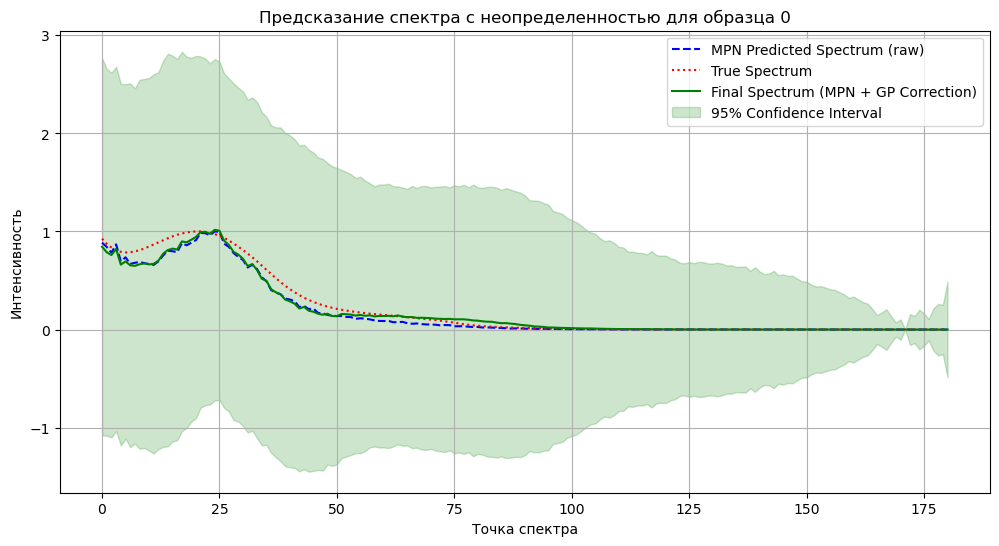

In [22]:
sample_idx = 0

plt.figure(figsize=(12, 6))
plt.plot(Y_pred_test_scaled[sample_idx], label='MPN Predicted Spectrum (raw)', color='blue', linestyle='--')
plt.plot(Y_true_test[sample_idx], label='True Spectrum', color='red', linestyle=':') # Истинный спектр для сравнения
plt.plot(final_spectrum_mean[sample_idx], label='Final Spectrum (MPN + GP Correction)', color='green')
plt.fill_between(range(spectrum_len),
                 (final_spectrum_mean[sample_idx] - 2 * final_spectrum_std[sample_idx]),
                 (final_spectrum_mean[sample_idx] + 2 * final_spectrum_std[sample_idx]),
                 alpha=0.2, color='green', label='95% Confidence Interval')
plt.title(f'Предсказание спектра с неопределенностью для образца {sample_idx}')
plt.xlabel('Точка спектра')
plt.ylabel('Интенсивность')
plt.legend()
plt.grid(True)
plt.show()

# Сохранение GPflow моделей
save_dir = 'gp_models_checkpoint_gpflow' # Изменяем имя директории, чтобы не конфликтовать с GPyTorch
os.makedirs(save_dir, exist_ok=True)

In [15]:
save_dir = 'gp_models_checkpoint_gpflow' # Изменяем имя директории, чтобы не конфликтовать с GPyTorch
os.makedirs(PATH2fold0 +save_dir, exist_ok=True)
for i, model in enumerate(gp_models):
    # GPflow сохраняет параметры модели в формате Checkpoint или HDF5
    # Для GPR модели проще всего сохранить ее целиком
    # Замораживаем модель, чтобы получить immutable dict ее параметров
    params = gpflow.utilities.freeze(model)
    # Затем можно сохранить этот словарь параметров, например, в файл numpy
    np.save(os.path.join(PATH2fold0+save_dir, f'gp_model_{i}_params.npy'), params)
    
    # Для восстановления нужно будет загрузить параметры и создать новую модель GPR
    # Пример загрузки:
    # loaded_params = np.load(os.path.join(save_dir, f'gp_model_{i}_params.npy'), allow_pickle=True).item()
    # loaded_model = gpflow.models.GPR(
    #     (X_gp_train, Y_residuals_train[:, i:i+1]), # Нужны train_x и train_y для инициализации
    #     kernel=gpflow.kernels.SquaredExponential(), # Указать то же ядро, что и при сохранении
    #     mean_function=None
    # )
    # gpflow.utilities.recursive_update(loaded_model, loaded_params)

print(f"Все GP модели (параметры) сохранены в директории: {save_dir}")

Все GP модели (параметры) сохранены в директории: gp_models_checkpoint_gpflow
